# Benchmarking code to generate Figs 2 and 3 of the accompanying paper

Run the cells below to plot performance graphs.

The following parameters are used in the benchmarking scenario, representing a typical light field workload

| Parameter | Value |
| --------------- | ------- |
| Numerical Aperture | 0.5  |
| Magnification | 22.222   |
| ML Pitch ($\mu$m) | 125 |
| $f_\textrm{ML}$ ($\mu$m) | 3125  |
| Refractive index | 1.33   |
| $\lambda$ (nm) | 520 |
| $z$ range ($\mu$m) | ±60   |
| | |
| Number of planes | 25  |
| N | 19  |
| X | 1463   |
| Y | 1273   |
| $N_\textrm{iter}$ | 4 |


In [1]:
import py_light_field as plf
import benchmark

### Perform self-tests (optional)

In [2]:
import projector
import lfdeconv
import projector as proj
_ = projector.selfTest()
_ =  lfdeconv.main(['basic', 'full', 'parallel'])

Testing backprojection code against pure-python code
 Testing class: Projector_allC
  === bk True ===
  === shape (2, 150, 150) ===
   Old took 138.27ms
   New took 26.74ms
   Test result (should be <<1): 2.08616e-07
 -> OK
  === shape (2, 150, 300) ===
   Old took 158.44ms
   New took 39.08ms
   Test result (should be <<1): 2.08616e-07
 -> OK
  === shape (2, 300, 150) ===
   Old took 175.34ms
   New took 39.75ms
   Test result (should be <<1): 2.38419e-07
 -> OK
  === bk False ===
  === shape (2, 150, 150) ===
   Old took 121.49ms
   New took 36.58ms
   Test result (should be <<1): 3.57628e-07
 -> OK
  === shape (2, 150, 300) ===
   Old took 185.12ms
   New took 38.28ms
   Test result (should be <<1): 4.17233e-07
 -> OK
  === shape (2, 300, 150) ===
   Old took 144.90ms
   New took 41.97ms
   Test result (should be <<1): 3.8743e-07
 -> OK
 Testing class: Projector_python
  === bk True ===
  === shape (2, 150, 150) ===
   Old took 110.86ms
   New took 113.58ms
   Test result (should be

RL deconv:   0%|          | 0/8 [00:00<?, ?it/s]

Compare against matlab result (should be < 1.000000): 0.501892
 -> OK
Testing image pair deconvolution:
Running (9 planes x2)
New method took 16.959324836730957
Compare single and dual deconvolution #1 (should be <<1): 0
 -> OK
Compare single and dual deconvolution #2 (should be <<1): 0
 -> OK
Regression tests complete (passed 4/4)


# Testing thread scaling
For just the backprojection, the tests in the next cell take about an hour to run on suil-bheag (for 1-8 threads). This will generate a file `stats.txt`, but the subsequent code actually plots a file that is already in the repository recording the performance I previously recorded on my own server.

Interestingly, the thread scaling data looks very similar for the smaller image testcase.
The actual run time thread scaling looks a bit worse for the smaller testcase, but the scaling of CPU time used is similar in both cases (suggesting threads are idling in the smaller testcase)

The anomalously slow run-time for two threads on cuinneag is reproducible. I assume this is connected with the two-processor architecture, and is some sort of consequence of memory architecture and cache usage?

In [3]:
import benchmark
if False:
    # Smaller problem just to road-test this code and analysis
    threadScalingResults = benchmark.RunBenchmark(plat='cpu',
                                                  prefix=['smaller-image', 'x4'],
                                                  prefix2=['parallel-scaling'])
elif False:
    threadScalingResults = benchmark.RunBenchmark(plat='cpu',
                                                  prefix=['nils-image', 'nils-matrix', 'x16', 'i0'],
                                                  prefix2=['parallel-scaling'])
else:
    print("Will use previously-saved thread scaling data file")

Will use previously-saved thread scaling data file


Time fraction with 16 threads: 8.20%, 12.19x faster


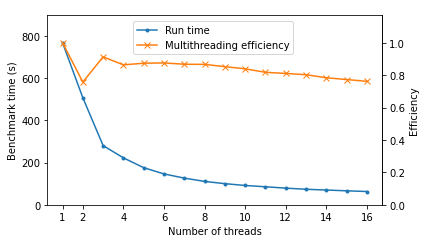

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
def PlotThreadStats(filename, rescaleAll=1, show=True):
    # rescaleAll: multiply all values by a constant factor (useful if doing multiple plots on top of each other)
    # show: call plt.show(). Disable this to allow plotting multiple plots on top of each other
    # forPaper: disable various annotations I don't want on the plot for the paper
    threadStats = []
    with open(filename) as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for row in csv_reader:
            threadStats.append(row)
    threadStats = np.array(threadStats).astype(np.float64)
    threadStats[:,1:] *= rescaleAll
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.title(filename)
    plt.xlabel("Number of threads")
    plt.ylabel("Benchmark time (s)")

    plt.plot(threadStats[:,0], threadStats[:,1], label='Run time')
    plt.plot(threadStats[:,0], threadStats[:,2]+threadStats[:,3], label='CPU time')
    plt.plot(threadStats[:,0], threadStats[:,1]*threadStats[:,0], label='Run time scaled')
    plt.ylim(0,None)
    plt.legend()
    plt.subplot(1,2,2)
    plt.title("{0} efficiency".format(filename))
    plt.plot(threadStats[:,0], threadStats[0,1]*threadStats[0,0]/(threadStats[:,1]*threadStats[:,0]), label='Efficiency')
    plt.ylim(0,None)
    if show:
        plt.show()
    
def PlotThreadStatsForPaper(filename):
    # rescaleAll: multiply all values by a constant factor (useful if doing multiple plots on top of each other)
    # show: call plt.show(). Disable this to allow plotting multiple plots on top of each other
    # forPaper: disable various annotations I don't want on the plot for the paper
    threadStats = []
    with open(filename) as f:
        csv_reader = csv.reader(f, delimiter='\t')
        for row in csv_reader:
            threadStats.append(row)
    threadStats = np.array(threadStats).astype(np.float64)
    fig, ax = plt.subplots(figsize=(6,3.5))
    fdMapping = lambda y: y/threadStats[0,1]
    bkMapping = lambda y: y*threadStats[0,1]
    ax2 = ax.secondary_yaxis('right', functions=(fdMapping, bkMapping))
    ax.set_xlabel("Number of threads")
    ax.set_ylabel("Benchmark time (s)")
    ax2.set_ylabel("Efficiency")

    ax.plot(threadStats[:,0], threadStats[:,1], marker='.', label='Run time')
    ax.set_xticks([1] + list(range(2, 17, 2)))
    ax.set_ylim(0,900)
    ax.set_yticks(range(0, 801, 200))
    ax2.set_yticks(np.arange(0, 1.01, 0.2))
    ax.plot(threadStats[:,0], 
            bkMapping(threadStats[0,1]*threadStats[0,0]/(threadStats[:,1]*threadStats[:,0])), 
            marker='x',
            label='Multithreading efficiency')
    leg = fig.legend(loc='upper center', borderaxespad=3.8)
    fig.savefig("thread_scaling.pdf")
    # The next two lines are a cosmetic workaround.
    # For some reason I need a larger borderaxespad for the saved pdf figure,
    # compared to the one displayed inline in this notebook
    leg.remove()
    fig.legend(loc='upper center', borderaxespad=2.2)
    #fig.show()
    factor = threadStats[-1,1]/threadStats[0,1]
    print(f"Time fraction with 16 threads: {100*factor:.2f}%, {1/factor:.2f}x faster")

# Plot thread scaling statistics from a previously-saved log file
PlotThreadStatsForPaper('stats_large_cuinneag.txt')

# Testing batch scaling

Look at how runtime scales with batch size. To run this on your own machine, edit the code below to create empty arrays batchScalingResultsCPU and batchScalingResultsGPU, and the code will automatically run benchmarks for every batch size specified in batchSizesCPU/GPU.

Initially I just looked at the backprojection here, to keep the run times manageable. It's satisfying to see that the results are very well modelled by a fixed overhead (presumably calculation of F(H)) plus an extra factor that scales very linearly with the batch size.

Relatively speaking, the GPU baseline is much lower (i.e. we don't need as large a batch size to amortise it away). That's good news in terms of GPU RAM consumption. However, it does lead me to suspect that my GPU implementation of my special FFT is less optimised. It's *possible* the GPU is just less good at that, but it probably means I could be doing more to optimise that code, if I really put my mind to it.

The same pattern seems to apply to the full deconvolution (which I've sampled for a few batch sizes), and it's gratifying to see that we don't pick up any additional overheads or penalties here.

In [5]:
import benchmark
import projector as proj
import numpy as np

if True:
    # Datasets calculated earlier on suil-bheag CPU and GPU
    print("Using data from suil-bheag")
    batchSizesGPU = np.array(1+np.arange(24))
    batchScalingResultsGPU = [2.0887858867645264, 2.650907516479492, 3.1582248210906982, 3.639864206314087, 4.187718629837036, 4.7083728313446045, 5.515699625015259, 6.032058954238892, 6.538254976272583, 6.759566068649292, 7.901719570159912, 7.820116281509399, 9.093420267105103, 8.917783260345459, 9.327208280563354, 9.943439483642578, 11.797546148300171, 11.179245710372925, 12.977349758148193, 12.188851594924927, 12.5778169631958, 13.543910503387451, 14.43958854675293, 14.407610893249512]

    batchSizesCPU = np.array(list(range(1,8,1)) + list(range(8,16,2)) + list(range(16,33,4)))
    batchScalingResultsCPU = [70.64740204811096,77.01506614685059,84.01113772392273,90.80544757843018,98.12121725082397,
                                  104.44658899307251,111.3729362487793,117.50704097747803,131.72836804389954,144.44977974891663,
                                  156.9799840450287,170.16073203086853,197.4131510257721,223.088045835495,249.77226161956787,
                                  274.7552146911621]

    batchSizesGPUdc = np.array([1, 2, 4, 8, 16, 24])
    batchScalingResultsGPUdc = [19.04511833190918, 23.87207317352295, 36.4692268371582, 51.96277904510498, 91.1813862323761, 135.37568163871765]

    batchSizesCPUdc = np.array([1, 2, 4, 8, 16, 32])
    batchScalingResultsCPUdc = [628.8385584354401, 686.4196479320526, 811.7965116500854, 1050.5633614063263, 1522.4902625083923, 2508.4796035289764]
else:
    # Datasets calculated earlier on macbook CPU
    print("Using data from macbook pro")
    # setup.py basic benchmarking results: [[2.9634785652160645, 2.926506519317627, 3.040677785873413, 2.7863423824310303], [1.3397929668426514, 1.3884947299957275, 1.3806533813476562, 1.3544728755950928]]
    batchSizesCPU = np.array([1, 32])
    batchScalingResultsCPU = [105.0, 449.6]

    batchSizesCPUdc = np.array([1, 32])
    batchScalingResultsCPUdc = [916.7, 4480.0]

# These loops will only calculate any missing entries that are not yet present in the above precalculated arrays,
# to avoid taking ages to run this cell every time you just want to analyze the results
for batchSize in batchSizesCPU[len(batchScalingResultsCPU):]:
    # Benchmark for this batch size
    results = benchmark.RunBenchmark('cpu', prefix=['nils-image', 'nils-matrix', f'x{batchSize}'])
    batchScalingResultsCPU.append(results[0])
    
if proj.gpuAvailable:
    for batchSize in batchSizesGPU[len(batchScalingResultsGPU):]:
        # Benchmark for this batch size
        results = benchmark.RunBenchmark('gpu', prefix=['nils-image', 'nils-matrix', f'x{batchSize}', 'volumes-on-gpu'])
        batchScalingResultsGPU.append(results[0])
        # These next lines clear the FFT plan cache.
        # In every loop iteration we compute different-shaped FFTs, so the cached plans
        # are just taking up memory without being useful. Without clearing like this,
        # we gradually fill up the GPU memory with redundant cached data.
        import cupy as cp
        cp.fft.config.get_plan_cache().clear()
else:
    print("No GPU available - not benchmarking")    
    

# Run the full deconvolution for a limited set of batch sizes, just to confirm that the scalings still apply
for batchSize in batchSizesCPUdc[len(batchScalingResultsCPUdc):]:
    results = benchmark.RunBenchmark('cpu', prefix=['nils-image', 'nils-matrix', 'i4', f'x{batchSize}'])
    batchScalingResultsCPUdc.append(results[0])    
if proj.gpuAvailable:    
    for batchSize in batchSizesGPUdc[len(batchScalingResultsGPUdc):]:
        results = benchmark.RunBenchmark('gpu', prefix=['volumes-on-gpu', 'nils-image', 'nils-matrix', 'i4', f'x{batchSize}'])
        batchScalingResultsGPUdc.append(results[0])    
        # As noted above, these next lines release GPU memory after each test
        import cupy as cp
        cp.fft.config.get_plan_cache().clear()
else:
    print("No GPU available - not benchmarking")

Using data from suil-bheag
No GPU available - not benchmarking
No GPU available - not benchmarking


cpu_deconv.pdf baseline: 565.69s. Gradient: 60.55s/image
gpu_deconv.pdf baseline: 14.01s. Gradient: 4.98s/image


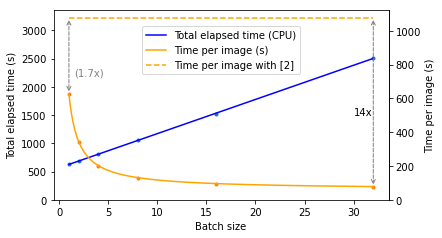

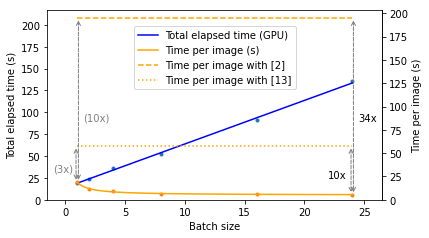

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def PlotResults(batchSizes, batchScalingResults, desc):
    batchScalingResults = np.array(batchScalingResults)
    batchSizes = batchSizes[:len(batchScalingResults)]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Time ({0})".format(desc))
    plt.xlabel("Batch size")
    plt.ylabel("Time (s)")
    plt.plot(batchSizes, batchScalingResults)
    plt.plot(batchSizes, batchScalingResults, '.')
    mc = np.polyfit(batchSizes, batchScalingResults, 1)
    plt.plot(batchSizes, mc[0]*batchSizes+mc[1])
    plt.ylim(0,None)
    
    plt.subplot(1,2,2)
    plt.title("Time per image ({0})".format(desc))
    plt.xlabel("Batch size")
    plt.ylabel("Time (s)")
    plt.plot(batchSizes, batchScalingResults / batchSizes)
    plt.plot(batchSizes, batchScalingResults / batchSizes, '.')
    plt.ylim(0,None)
    plt.show()
    print("{0} baseline: {1:.2f}s. Gradient: {2:.2f}s/image".format(desc, mc[1], mc[0]))
    
def PlotResultsPaper(batchSizes, batchScalingResults, filename, desc):
    batchScalingResults = np.array(batchScalingResults)
    batchSizes = batchSizes[:len(batchScalingResults)]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_xlabel("Batch size")
    ax.set_ylabel("Time (s)")
    fdMapping = lambda y: y*batchScalingResults[0]/batchScalingResults[-1]
    bkMapping = lambda y: y/batchScalingResults[0]*batchScalingResults[-1]
    ax2 = ax.secondary_yaxis('right', functions=(fdMapping, bkMapping))
    ax2.set_ylabel("Time per image (s)")

    ax.plot(batchSizes, batchScalingResults, '.')
    mc = np.polyfit(batchSizes, batchScalingResults, 1)
    ax.plot(batchSizes, mc[0]*batchSizes+mc[1], color='blue', label=f'Total elapsed time ({desc})')
    ax.set_ylim(0,None)
    
    ax.plot(batchSizes, bkMapping(batchScalingResults / batchSizes), '.')
    batchSizes2 = np.arange(1, batchSizes[-1]+1e-6, 0.01)
    ax.plot(batchSizes2, bkMapping((mc[0]*batchSizes2+mc[1])/batchSizes2), color='orange', label='Time per image (s)')

    leg = fig.legend(loc='upper center', borderaxespad=4.2)
    fig.savefig(filename)
    # The next two lines are a cosmetic workaround.
    # For some reason I need a larger borderaxespad for the saved pdf figure,
    # compared to the one displayed inline in this notebook
    leg.remove()
    fig.legend(loc='upper center', borderaxespad=2.5)
    fig.show()
    print("{0} baseline: {1:.2f}s. Gradient: {2:.2f}s/image".format(filename, mc[1], mc[0]))
    
def do_nothing(*args):
    return None

def PlotResultsPaperRevised(batchSizes, batchScalingResults, filename, desc, prevedelVal, rescale, annotate=do_nothing):
    batchScalingResults = np.array(batchScalingResults)
    batchSizes = batchSizes[:len(batchScalingResults)]
    fig, ax = plt.subplots(figsize=(6,3.5))
    ax.set_xlabel("Batch size")
    ax.set_ylabel("Total elapsed time (s)")
    fdMapping = lambda y: np.asarray(y)*batchScalingResults[0]/batchScalingResults[-1]/rescale
    bkMapping = lambda y: np.asarray(y)/batchScalingResults[0]*batchScalingResults[-1]*rescale
    ax2 = ax.secondary_yaxis('right', functions=(fdMapping, bkMapping))
    ax2.set_ylabel("Time per image (s)")

    ax.plot(batchSizes, batchScalingResults, '.')
    mc = np.polyfit(batchSizes, batchScalingResults, 1)
    ax.plot(batchSizes, mc[0]*batchSizes+mc[1], color='blue', label=f'Total elapsed time ({desc})')
    
    ax.plot(batchSizes, bkMapping(batchScalingResults / batchSizes), '.')
    batchSizes2 = np.arange(1, batchSizes[-1]+1e-6, 0.01)
    ax.plot(batchSizes2, bkMapping((mc[0]*batchSizes2+mc[1])/batchSizes2), color='orange', label='Time per image (s)')

    annotate(fdMapping, bkMapping, batchScalingResults/batchSizes, prevedelVal)

    ax.set_ylim(0,None)

    leg = fig.legend(loc='upper center', borderaxespad=5.3)
    fig.savefig(filename)
    # The next two lines are a cosmetic workaround.
    # For some reason I need a larger borderaxespad for the saved pdf figure,
    # compared to the one displayed inline in this notebook
    leg.remove()
    fig.legend(loc='upper center', borderaxespad=2.7)
    #fig.show()
    print("{0} baseline: {1:.2f}s. Gradient: {2:.2f}s/image".format(filename, mc[1], mc[0]))    
    
def AddComparatorsCPU(fdMapping, bkMapping, batchScalingResults, prevedelVal):
    plt.plot([1,32], bkMapping([prevedelVal, prevedelVal]), '--', color='orange', label='Time per image with [2]')
    plt.annotate('', (1,bkMapping(batchScalingResults[0])), (1,bkMapping(prevedelVal)), arrowprops={'arrowstyle': '<->', 'color': 'gray', 'linestyle': 'dashed'})
    plt.annotate(f'({prevedelVal/batchScalingResults[0]:.2g}x)', (1.5,2200), color='gray') # 1.7x
    plt.annotate('', (32,bkMapping(batchScalingResults[-1])), (32,bkMapping(prevedelVal)), arrowprops={'arrowstyle': '<->', 'color': 'gray', 'linestyle': 'dashed'})
    plt.annotate(f'{prevedelVal/batchScalingResults[-1]:.2g}x', (30,1500), color='black') # 14x
    
def AddComparatorsGPU(fdMapping, bkMapping, batchScalingResults, prevedelVal):
    napariVal = 57.4
    plt.plot([1,24], bkMapping([prevedelVal, prevedelVal]), '--', color='orange', label='Time per image with [2]')
    plt.annotate('', (1.1,bkMapping(batchScalingResults[0])), (1.1,bkMapping(prevedelVal)), arrowprops={'arrowstyle': '<->', 'color': 'gray', 'linestyle': 'dashed'})
    plt.annotate(f'({prevedelVal/batchScalingResults[0]:.2g}x)', (1.5,90), color='gray') # 10x
    plt.annotate('', (24.1,bkMapping(batchScalingResults[-1])), (24.1,bkMapping(prevedelVal)), arrowprops={'arrowstyle': '<->', 'color': 'gray', 'linestyle': 'dashed'})
    plt.annotate(f'{prevedelVal/batchScalingResults[-1]:.2g}x', (24.5,90), color='black') # 34x
    plt.plot([1,24], bkMapping([napariVal, napariVal]), ':', color='orange', label='Time per image with [13]')
    plt.annotate('', (0.9,bkMapping(batchScalingResults[0])), (0.9,bkMapping(napariVal)), arrowprops={'arrowstyle': '<->', 'color': 'gray', 'linestyle': 'dashed'})
    plt.annotate(f'({napariVal/batchScalingResults[0]:.2g}x)', (-1.0,32), color='gray') # 3x
    plt.annotate('', (23.9,bkMapping(batchScalingResults[-1])), (23.9,bkMapping(napariVal)), arrowprops={'arrowstyle': '<->', 'color': 'gray', 'linestyle': 'dashed'})
    plt.annotate(f'{napariVal/batchScalingResults[-1]:.2g}x', (22,25), color='black') # 10x
    plt.xlim(-1.5,26.5)

if False:
    PlotResults(batchSizesCPU, batchScalingResultsCPU, "CPU")
    PlotResults(batchSizesGPU, batchScalingResultsGPU, "GPU")
    PlotResults(batchSizesCPUdc, batchScalingResultsCPUdc, "CPU deconv")
    PlotResults(batchSizesGPUdc, batchScalingResultsGPUdc, "GPU deconv")

PlotResultsPaperRevised(batchSizesCPUdc, batchScalingResultsCPUdc, "cpu_deconv.pdf", "CPU", 1075.9, 0.75, AddComparatorsCPU)
PlotResultsPaperRevised(batchSizesGPUdc, batchScalingResultsGPUdc, "gpu_deconv.pdf", "GPU", 194.5, 0.15, AddComparatorsGPU)

# Reviewer-requested comparison between reconstructed stacks
Ultimately the equations are exactly the same in my code vs Matlab, so any discrepancies are simply down to rounding errors, order of evaluation, etc.
Despite this, reviewers requested I state the SSIM - so this code computes that.

Note that the benchmarking above is done with only 4 iterations, because the run time scales very reproducibly with number of iterations so there's no point taking twice as long to generate the extensive benchmarks for thread and batch size scaling.
For this image comparison it seems more appropriate to use the 8 iterations that the Prevedel/Yoon code chooses as its default. Not that it matters though - the SSIM is going to be 1.000000, however many iterations we choose to compare after.

### 8 iteration reconstruction to compare with Matlab

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import benchmark
from skimage.metrics import structural_similarity

In [8]:
# Compare our file (generated using the code above) with the one generated by Matlab
try:
    ours = tifffile.imread('performance_analysis_output_unnorm_i8.tif')
except:
    print("Output file not found - we will generate it now")
    benchmark.RunBenchmark('cpu',
            prefix=['nils-image', 'nils-matrix-matlab', 'i8', 'x1'],
            suffix=['save-last-output'],
            outputFilename='performance_analysis_output_unnorm_i8.tif')
    ours = tifffile.imread('performance_analysis_output_unnorm_i8.tif')
        
# Apply the same normalisation as used in the Prevedel/Yoon matlab code, 
# allowing for direct comparison between the two reconstructions.
ours = np.round(65535*ours/np.max(ours)).astype(np.uint16)

# The Matlab file can be generated by running Reconstruction3D_headless.m,
# after editing it to override the following settings:
#   PSFfile = 'PSFmatrix_M22.222NA0.5MLPitch125fml3125from-60to60zspacing5Nnum19lambda520n1.33.mat'
#   inputFileName = 'Nils_LFImage.tif';
#   maxIter = 8;
#   LastFrame = 1;
theirs = tifffile.imread('Recon3D_Nils_LFImage_1_i8.tif')

SSIM: 0.9999999996040257 (8 sig figs: 1.00000000)


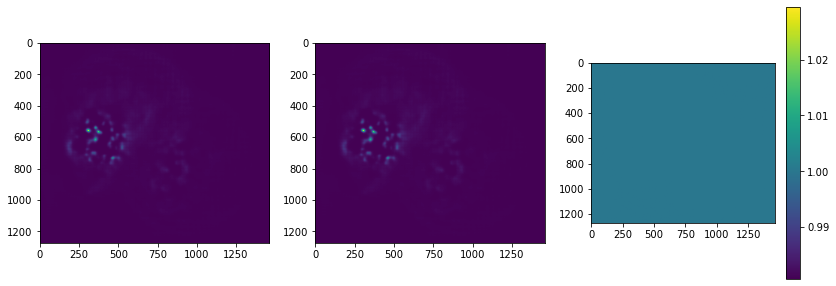

In [9]:
(score, diff) = structural_similarity(ours, theirs, full=True)
print(f'SSIM: {score} (8 sig figs: {score:.8f})')

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(theirs[0])
plt.subplot(1,3,2)
plt.imshow(ours[0])
plt.subplot(1,3,3)
plt.imshow(ours[0]/theirs[0])
plt.colorbar()
plt.show()

### 8 iteration reconstruction to compare with napari-lf
They use a different PSF model and different reconstruction details, so we would not expect a perfect match. But this comparison reassures that we are doing basically the same reconstruction. Note that I used a 'rect' lenslet shape for napari-lf. The Prevedel/Yoon PSF model is actually a circular lenslet, but in that scenario napari-lf masks the projections in such a way that the native focal plane footprints look circular rather than square. As a consequence, the 'rect' shape gives a better visual comparison between the two. We are not aiming for bitwise identical images here (as we are with Prevedel/Yoon), we are just looking to verify that the reconstruction I ran is equivalent, and therefore a fair comparison in terms of run time

In [10]:
# Compare our file (generated using the code above) with the one generated by napari-lf
try:
    ours = tifffile.imread('performance_analysis_output_fdnorm_i8.tif')
except:
    print("Output file not found - we will generate it now")
    ours = benchmark.RunBenchmark('cpu',
                                  prefix=['nils-image', 'nils-matrix', 'i8', 'x1'],
                                  suffix=['save-last-output'],
                                  outputFilename='performance_analysis_output_fdnorm_i8.tif')

# The file from napari-lf can be generated by running the following two commands
# from within that the napari-lf directory:
#     python lfcalibrate.py -o nils-calibration.lfc --synthetic --pitch 125 --pixel-size 6.579 --tubelens-focal-length 200 --ns 77 --nt 67 --focal-length 3125 --magnification 22 --na 0.5 --wavelength 520 --medium-index 1.33 --ulens-fill-factor 1.0 --pixel-fill-factor 1.0 --ulens-profile 'circ' --num-slices 25 --um-per-slice 5 --z-center 0 --use-single-precision --disable-gpu --skip-alignment --skip-subpixel-alignment --radiometry-frame ‘radiometry.tif’ --supersample 19
#     python lfdeconvolve.py Nils_test_LFImage.tif -o Nils_LFImage_deconvolved_napari.tif -c nils-calibration.lfc --max-iter 4 --use-single-precision
theirs = tifffile.imread('Nils_LFImage_deconvolved_napari_rect_i8.tif')

# Normalise their data to allow direct comparison
# They also generate the stack with the opposite z direction convention,
# so we need to flip the stack to match
theirs = np.round(65535*theirs/np.max(theirs)).astype(np.uint16)[::-1,:,:]
# They do not reconstruct the outermost lenslet footprint (it is forced to zero)
# That obviously impacts the comparison.
# It seems fair to zero out ours to match theirs in that regard.
# Otherwise theirs would be penalised for not matching.
ours[:,:19,:] = 0
ours[:,-19:,:] = 0
ours[:,:,:19] = 0
ours[:,:,-19:] = 0

SSIM: 0.9884208633482959 (6 sig figs: 0.988421)


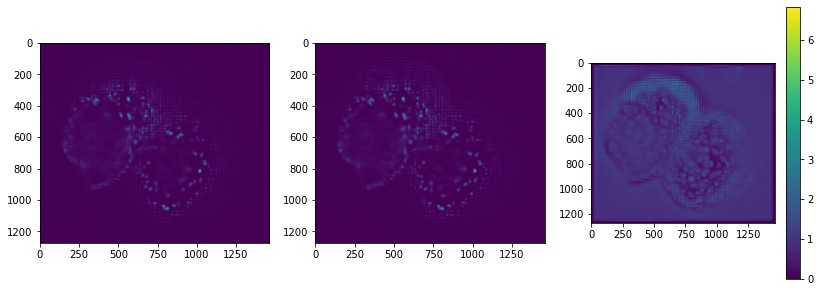

In [11]:
(score, diff) = structural_similarity(ours, theirs, full=True)
print(f'SSIM: {score} (6 sig figs: {score:.6f})')

plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.imshow(theirs[10])
plt.subplot(1,3,2)
plt.imshow(ours[10])
plt.subplot(1,3,3)
plt.imshow(ours[10]/theirs[10])
plt.colorbar()
plt.show()

### Comparison with Olaf
I did not compare with the Olaf software to the same level of detail, since it was clear that it ran significantly slower than the Prevedel/Yoon code for some reason (and had a significantly larger memory footprint). 

The file `LFMconfig.yaml` provides the appropriate PSF parameters in the format required by Olaf (thanks to Nils Norlin for sharing the file along with his data). The Olaf source file `mainLFM.m` requires the following edits:

    depthRange = [-60, 60]; %Full reconstruction depth range (im um)
    depthStep = 5; % axial resolution (in um)
    newSpacingPx = 19; % 'default' means no up/down-sampling (newSpacingPx = lensPitch/pixelPitch)
    WhiteImage = []; % Force use of theoretical parameters only
    imgSize = [1273,1463]

and various small bug fixes to the Olaf codebase are required (as of May 2023) to enable it to run without a calibration white image. That is evidently an intended feature of the software, but that part of the code seems to be a bit neglected and leads to some runtime errors.

##  Work in progress: look at a specific case where forward projection seems like it could be speeded up
I had noticed that forward projection was a bit slower than backprojection on my macbook (although I have not seen this on other platforms), and it would be nice to get to the bottom of this performance anomaly. The cells below are my work in progress trying to investigate why...

I am struggling to reproduce this, actually. With Nils' image and x16 I maybe have slightly elevated rusage for forward projection, but no clear difference in overall run time. With Nils x32 on cuinneag I see no trend at all.

I haven't yet rerun x32 on macbook pro, I wonder if that will show the problem again or if it will have gone away??

In [ ]:
# See if I see this on a smaller testcase that's easier to play with

''' 
    Nils, x16, macbook
        Running with batch image shape (16, 1463, 1273), batch x16
        work elapsed wallclock time 260.581940
        Total work delta rusage: [1002.017153   25.666372]
        work elapsed wallclock time 267.333674
        Total work delta rusage: [1024.208123   28.725325]
        work elapsed wallclock time 267.539262
        Total work delta rusage: [993.014693  33.542868]
        work elapsed wallclock time 264.884809
        Total work delta rusage: [1011.825912   29.671406]
        work elapsed wallclock time 267.695029
        Total work delta rusage: [1001.905267   29.950696]
    time: 1329.85. overall delta rusage: [5033.941084  148.399634]
    
    Nils, x32, cuinneag
        Running with batch image shape (32, 1463, 1273), batch x32
        work elapsed wallclock time 104.480644
        Total work delta rusage: [1511.719767   44.051956]
        work elapsed wallclock time 104.862145
        Total work delta rusage: [1518.188842   53.990656]
        work elapsed wallclock time 109.053886
        Total work delta rusage: [1531.75683    52.955494]
        work elapsed wallclock time 104.540129
        Total work delta rusage: [1531.171942   41.989661]
        work elapsed wallclock time 108.401333
        Total work delta rusage: [1519.177746   56.641623]
    time: 533.41. overall delta rusage: [7613.053808  250.65336 ]

'''
import benchmark
import projector as proj
import numpy as np

batchSizesCPUdc = np.array([1, 16])
batchScalingResultsCPUdc = []

import py_light_field as plf
plf.SetProgressReportingInterval(10.0)

# Run the full deconvolution for a limited set of batch sizes, just to confirm that the scalings still apply
for batchSize in batchSizesCPUdc[len(batchScalingResultsCPUdc):]:
    # Doesn't seem to occur for non-Nils x16:
    #batchScalingResultsCPUdc.append(benchmark.RunBenchmark(prefix=['i2', f'x{batchSize}'])[0][0])
    #batchScalingResultsCPUdc.append(benchmark.RunBenchmark(prefix=['nils-image', 'nils-matrix', 'i2', f'x{batchSize}'])[0][0])
    batchScalingResultsCPUdc.append(benchmark.RunBenchmark(prefix=['nils-image', 'nils-matrix', 'i1', f'x{batchSize}'])[0][0])

In [ ]:
import benchmark
# Testing same mini-scenario as I was testing in matlab
benchmark.RunBenchmark(prefix=['nils-image', 'nils-matrix-reduced', 'i4', 'x4'])